In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SARA_cornell_funcs import *
from scipy.special import wofz
import glob
import os
import sys
sys.path.insert(0,'/home/vandover/sara-scripts-and-notebooks/MCBL/')

# from MCBL import *
# from WaferMapper import WaferMap
# from TauT_Mapper import TauT

In [2]:
#new functions
def Symmetrize(data,center,plotting=False):
    """Return the symmetryized signal given the data and the center index
    data = (1D array) the data to be symmetrized
    center = (int) the index of the center value of the signal
    plotting = (bool) Troubleshooting plot
    """
    x = np.arange(len(data))
    x_l = x[x<center]
    x_r = x[x>center]
    
    d_l = data[x<center]
    d_r = data[x>center]
    
    #find which side is larger
    short = min(len(x_l),len(x_r))
#     print(abs(len(x_l)-len(x_r)))
    d_avg = 0.5*(d_l[-short:]+d_r[:short][::-1])
    
    center = int(round(center))
    sym = np.hstack((d_avg,data[center],d_avg[::-1]))
    if len(x_l)>len(x_r):
        extra = d_l[:abs(len(x_l)-len(x_r))]
        sym_data = np.hstack((extra,sym))
    elif len(x_l)<len(x_r):
        extra = d_r[-abs(len(x_l)-len(x_r)):]
        sym_data = np.hstack((sym,extra))
    elif len(x_l)==len(x_r):
        sym_data = sym
    
    sym_data = sym_data/max(sym_data)
#     print('shape check',len(sym_data),len(data))
    if plotting:
        fig,ax = plt.subplots(4,1,constrained_layout=True)
        #original data
        ax[0].plot(data)
        ax[0].axvline(center,c='goldenrod')
        
        ax[1].plot(x_l,d_l,c='b')
        ax[1].plot(x_r,d_r,c='r')
        
#         ax[2].plot(d_avg)
        ax[2].plot(sym,c='darkorchid')
        
        ax[3].plot(sym_data,c='k')
        plt.show()
        plt.close()
    
    return sym_data

def TransitionFinder(data,bkgd_ROI=[15,-15],sig=5,prom_filt=0.1,plotting=False):
    """Returns the indicies of the peaks in the signal
    data = (1D array) signal you want the peaks of
    bkgd_ROI = (int) the number of points on either end of the signal used to calculate the backgroudn
    sig = (int) the number of standard deviations above the background noise used to define a peak
    prom_filt = (float) the prominence filtering of the peak
    plotting = (bool) Troubleshooting plot
    """
    bkgd_mu = 0.5 * (np.mean(data[:bkgd_ROI[0]]) + np.mean(data[bkgd_ROI[1]:]))
    bkgd_std = 0.5 * (np.std(data[:bkgd_ROI[0]]) + np.std(data[bkgd_ROI[1]:]))
    hfilt = sig * bkgd_std
    wfilt = [0.001*len(data),0.25*len(data)]
    data = data - bkgd_mu
    
    
    peak_idx,stats = signal.find_peaks(data,height=hfilt,prominence=prom_filt,width=wfilt)
    
    if plotting:
        fig,ax = plt.subplots(1,1)
        ax.plot(data,label= 'data')
        for p in peak_idx:
            ax.axvline(p,c='goldenrod')
        ax.set_xlabel("signal index")
        ax.set_ylabel("signal intensity")
        ax.axvspan(0, bkgd_ROI[0], color='darkorchid', alpha=0.5, lw=1,label='left noise floor')
        ax.axvspan(len(data)+bkgd_ROI[1], len(data), color='darkorchid', alpha=0.5, lw=1,label='right noise floor')
#         ax.legend()
        
        
        plt.show()
        plt.close()
    
    return peak_idx, stats

def PhaseRegions(techmap,trs,plotting=False):
    """Returns the average signal of each measurement bounded by the transitions identified in each map
    techmap = (ndarray) the heatmap of the data
    trs = (list) a list of intergers corresponding to the indicies of the transformations
    plotting = (bool) Troubleshooting plot
    
    """
    avg_ROIs = []
    ROI_bounds = []
    
    bounded_trs = np.hstack((0,trs,techmap.shape[1]))
#     print(bounded_trs)
    for idx in np.arange(len(bounded_trs)-1):
#         print(bounded_trs[idx],bounded_trs[idx+1])
        ROI = techmap[:,bounded_trs[idx]:bounded_trs[idx+1]]
        avg_ROI = np.average(ROI,axis=1)
        ROI_bounds.append([bounded_trs[idx],bounded_trs[idx+1]])
        if plotting:
            fig,ax = plt.subplots(2,1)
            ax[0].imshow(ROI,aspect='auto')
            ax[1].plot(avg_ROI)
            plt.show()
            plt.close()
        avg_ROIs.append(avg_ROI)
    
    oneside = []
    
    for idx in np.arange((len(avg_ROIs)-1)/2,dtype=int):
#         print(idx)
        equal_ROI = 0.5*(avg_ROIs[idx]+avg_ROIs[-idx])
        oneside.append(equal_ROI)
#     print(int((len(avg_ROIs)-1)/2+1))
    oneside.append(avg_ROIs[int((len(avg_ROIs)-1)/2)])
    
    return oneside,avg_ROIs,ROI_bounds

def spectral_reconstruct(Q,peakpos,heights,widths,HWHM=0.01,norm=True,plotting=False):
    """
    A pseudo spectra of summed Voigt functions for the diffraction data. 
    
    Q : (arr) of the spanning Q values for the spectra
    peakpos: (arr) indicies of the peaks (not Q)
    heights: (arr) same shape as peakpos, but containing the heights
    widths: (arr) same shape as peakpos, but contains the widths of the peaks substituted into the FWHM argument
    
    returns an array of intensities of shape Q
    """
    pseudo_specs =[]
    for p,h,w in zip(peakpos,heights,widths):
#         print(p,h,w)
        w = w*(Q[1]-Q[0])
#         peakfunction = Voigt(x=Q,background=0,height=h,position=Q[p],alpha=w,gamma=HWHM)
        peakfunction = Gaussian(x=Q,background=0,height=h,position=Q[p],FWHM=w)
        pseudo_specs.append(peakfunction)
#         pseudo_specs.append(Lorentz(x=Q,background=0,height=h,position=Q[p],HWHM=0.5))
    singlespec = np.sum(pseudo_specs,axis=0)
    if plotting:
        fig,ax = plt.subplots(2,1,dpi=150)
        for spec in pseudo_specs:
            ax[0].plot(Q,spec)
        ax[1].set_xlabel('Q in nm$^{-1}$')
        ax[0].set_ylabel('Intensity (a.u.)')
        ax[1].plot(singlespec)
        plt.show()
        plt.close()
    return singlespec

# Using the transition information from the output dictionary to identify potential ROIs/number of transitions

In [3]:
MatSysName = '19F44_test'
ptim = '/home/vandover/Documents/Data/19F44_Bi2O3/Images/'
# ptImgMirror = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/2020-06-02_Images/Mirror/2020-06-02_Mirror.bmp'
ptsp_raw = '/home/vandover/Documents/Data/19F44_Bi2O3/Data/'
ptsp_m = '/home/vandover/Documents/Data/19F44_Bi2O3/Data/BlanksAndMirrors/mirror_00.csv'
ptsp_b = '/home/vandover/Documents/Data/19F44_Bi2O3/Data/BlanksAndMirrors/blank_00.csv'
# pth5 = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/LaMnOx_18CIT49586_rerun_all_oned.h5'
OptDict = FpDict(ptim,ftype='.bmp')
SpecDict = FpDict(ptsp_raw,ftype='.csv')
# XrdDict = FpDict(pth5,Xrays=True)

In [13]:
list(SpecDict)
key = 'tau_10000_T_1280'
s = TechStripe()
s.fpb = ptsp_b
s.fpm = ptsp_m
s.fprs = SpecDict[key]['fp']
smap = s.Specmap(okey='tau_10000_T_1280',wlmax=900,wlmin=400)[1]
wl = s.wl
wl = wl
plt.imshow(smap,aspect='auto')
plt.show()

plt.plot(wl,smap)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2046 but corresponding boolean dimension is 1457

In [9]:
demkeys = dwellsort(list(OptDict))
outputD = {}
key = 'tau_250_T_800'
print(key)
#     print('')
#output dictionary to be read
outputD[key] = {}


#instantiate stripe
s = TechStripe()

#     s.h5file = pth5
s.fpo = OptDict[key]['fp']
s.fpb = ptsp_b
s.fpm = ptsp_m
s.fprs = SpecDict[key]['fp']
#     print(SpecDict[key]['fp'])
s.crop = (600,850)

#create opt and spec maps

omap = s.Optmap(okey=key,weights=[0,0,1],grayscale=False,Norm=False,Average=True,crop=(True,[600,850]))
#     omap = DustCollector(omap,binsize=15,exc_z=3,plotting=False)[0]
smap = s.Specmap(key)[1]
wl = s.wl

#     fig,ax = plt.subplots(3,1,dpi=150)
#     ax[1].plot(np.sum(omap,axis=0))
#     ax[1].plot(LinearBS(np.sum(omap,axis=0)))
g = np.gradient(np.sum(omap,axis=0))
g = smooth(np.sqrt(g*g))
og = g/max(g)
#     ax[0].imshow(omap)


#     og = Grad(omap,bound_avg=False,norm=True)[0]
sg = Grad(smap,bound_avg=True,norm=True)[0]

og = smooth(og,window_len=15)
sg = smooth(sg,window_len=5)
ocenter = np.round(CenterFinding(og,sparam=2,plotting=False))
scenter = np.round(CenterFinding(sg,sparam=2,plotting=False))

osym = Symmetrize(og,ocenter,plotting=False)
ssym = Symmetrize(sg,scenter,plotting=False)
#     #create XRD map
#     xmap = s.Xraymap(key,dpath=pth5)[:-24,:]
#     Q = s.Q[:-24]
#     outputD[key]['Q'] = Q
#     #Sharpen map
#     xmap = sharpen_y(xmap,alpha=0.25,bf=[1,1],fbf=[0.0,0.8],plotting=False)
#     #create the gradient and find the center
#     xg = Grad(xmap,bound_avg=True,norm=True)[0]
#     xcenter = np.round(CenterFinding(xg,sparam=2,plotting=False))
#     xsym = Symmetrize(xg,xcenter,plotting=False)


#find transformation boundaries
otrs,_ = TransitionFinder(data=osym,prom_filt=0.01,bkgd_ROI=[30,-30],plotting=False)
strs,_ = TransitionFinder(data=ssym,prom_filt=0.01,bkgd_ROI=[30,-30],plotting=False)


#identify unique phases and average
#     oneside,avg_ROIs,ROI_bounds = PhaseRegions(xmap,xtrs)

#     outputD[key]['DPs'] = {}
#     for idx,spec in enumerate(oneside):
#         outputD[key]['DPs'][str(idx)] = {}
#         outputD[key]['DPs'][str(idx)]['ROI average'] = spec

outputD[key]['spec_trs'] = strs
outputD[key]['opt_trs'] = otrs

tau_250_T_800


In [5]:
def FullConds(keys):
    """Returns the list of the full condition mesh as a list with the "tau_T" indexing
    
    keys: (list) of dictionary keys
    """
    taus = []
    Ts = []
    fullmesh = []
    for key in dwellsort(keys):
        s = key.split('_')
        taus.append(s[1])
        Ts.append(s[3])
    tauax = np.unique(taus)
    Tax = np.unique(Ts)
    
    
    fullmesh = [f'tau_{tau}_T_{T}'for tau in tauax for T in Tax]
    print(len(fullmesh),len(keys))
    missing = set(fullmesh)-set(keys)
    return fullmesh,missing
# FullConds(list(outputD))[1]

In [5]:
taus = []
Ts = []
ntrs_s = []
ntrs_o = []


for key in dwellsort(list(outputD)):
    conds = key.split('_')
    taus.append(int(conds[1]))
    Ts.append(int(conds[3]))
    ntrs_s.append(len(outputD[key]['spec_trs'])/2)
    ntrs_o.append(len(outputD[key]['opt_trs'])/2)
taus = np.array(taus).reshape(25,25)
Ts = np.array(Ts).reshape(25,25)
ntrs_s = np.array(ntrs_s).reshape(25,25)
ntrs_o = np.array(ntrs_o).reshape(25,25)


fig,ax = plt.subplots(1,1,dpi=150)
ax.set_title(f'{MatSysName} transitions from optical')
mplm = ax.pcolormesh(np.log10(taus),Ts,ntrs_o)
ax.set_xlabel('log dwell time')
ax.set_ylabel('Tmax in \u00B0C')
fig.colorbar(mplm)
plt.show()

fig,ax = plt.subplots(1,1,dpi=150)
ax.set_title(f'{MatSysName} transitions from spectroscopy')
mplm = ax.pcolormesh(np.log10(taus),Ts,ntrs_s)
ax.set_xlabel('log dwell time')
ax.set_ylabel('Tmax in \u00B0C')
plt.colorbar(mplm)
plt.show()

ValueError: cannot reshape array of size 617 into shape (25,25)

In [ ]:
pth5 = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/LaMnOx_18CIT49586_rerun_all_oned.h5'
XrdDict = FpDict(pth5,Xrays=True,json_friendly=True)
ptcomp = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/ana__2__tau.us-T.C-xw.mm.csv'
raw = np.genfromtxt(ptcomp,dtype=float,delimiter=',',skip_header=3)
#tau,T,x_mm,y_mm,La_frac
for idx in np.arange(len(raw)):
    taus = int(raw[idx,3])
    Ts = int(raw[idx,4])
    La_frac = raw[idx,7]
    xpos = raw[idx,5]
    ypos = raw[idx,6]
    
    key = f'tau_{taus}_T_{Ts}'
    XrdDict[key]['La_frac'] = str(La_frac)

In [ ]:
# import json
# with open('/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/18CIT49586_Conds_Dictionary.json','w') as fp:
#     json.dump(XrdDict,fp)
# DUPDICT = json.load(open('/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/18CIT49586_Conds_Dictionary.json'))
# DUPDICT

# import json
# savefp = '/home/vandover/Desktop/'
# with open(f'{savefp}18CIT49586_LaMnOx_Reconstruction_Dictionary.json', 'w') as fp:
#     json.dump(outputD, fp)

# XRD reconstruction for ML

The data are noisy, this is Duncan's attempt at extracting the important phase peak information (height, width, q-vector) and reconstructing (noiselessly) for NMF and phase identification.

key components are:
- getting the spatial gradient of the xrd map
- symmetrizing the stripe
- identifying unique phase regions (rank for NMF)
- peak finding from the phases
- reconstruction using gaussian, Lorenzian, or voigt functions

The data are passed into a dictionary for Ming or Sebastian to work off of


In [ ]:
demkeys = dwellsort(list(XrdDict))
outputD = {}

for key in demkeys:
    print('')
    print(key)
    print('')
    #output dictionary to be read
    outputD[key] = {}
    
    
    #instantiate stripe
    s = TechStripe()
    s.h5file = pth5
    
    #create XRD map
    xmap = s.Xraymap(key,dpath=pth5)[:-24,:]
    Q = s.Q[:-24]
    outputD[key]['Q'] = Q.tolist()
    
    
    #Sharpen map
    xmap = sharpen_y(xmap,alpha=0.25,bf=[1,1],fbf=[0.0,0.8],plotting=False)
    
    
    
    #create the gradient and find the center
    xg = Grad(xmap,bound_avg=True,norm=True)[0]
    xcenter = np.round(CenterFinding(xg,sparam=2,plotting=False))
    xsym = Symmetrize(xg,xcenter,plotting=False)
    
    
    #find transformation boundaries
    xtrs,_ = TransitionFinder(data=xsym,prom_filt=0.01,bkgd_ROI=[30,-30],plotting=False)
    
    
    #identify unique phases and average
    oneside,avg_ROIs,ROI_bounds = PhaseRegions(xmap,xtrs)
    
    outputD[key]['DPs'] = {}
    for idx,spec in enumerate(oneside):
        outputD[key]['DPs'][str(idx)] = {}
        outputD[key]['DPs'][str(idx)]['ROI average'] = spec.tolist()
        
    
    #background subtraction sample
    bkg_samp = 0.5*(np.average(xmap[:,:10],axis=1)+np.average(xmap[:,-10:],axis=1))
    mcbl = MCBL_UGM(Q=bkg_samp,I=np.array(oneside),rank=4,l=4)
    oneside = np.array(oneside) - mcbl.U.dot(mcbl.V) 
    
    spectra = []    
    for idx, i in enumerate(oneside):
        i[(Q>29)&(Q<32)] = 0.00001
        spectra.append(i)
        outputD[key]['DPs'][str(idx)]['MCBL'] = i.tolist()
        
        
    #generate the x coordinate
    xps = 10
    xx = np.linspace(0,xmap.shape[1]*xps,xmap.shape[1])
    
    phasepeaks = []
    pp_dicts = []
    smoothspec = []
    for spec in spectra:
        
        spec = ndimage.gaussian_filter1d(spec,0.5,mode='constant')

        sig = np.sqrt(np.var(spec[:50]))
        idxs,peakdicts = signal.find_peaks(
            spec,height=2*sig,prominence=3*sig,width=[0,0.25*len(spec)])
        phasepeaks.append(idxs)
        smoothspec.append(spec)
        pp_dicts.append(peakdicts)
        
    peak_heights = [pp_dicts[i]['peak_heights'] for i in np.arange(len(pp_dicts))]
    peak_widths  = [pp_dicts[i]['widths'] for i in np.arange(len(pp_dicts))]

    #iterating through the ROI averages and doing a diffraction pattern reconstruct
    for idx in np.arange(len(peak_heights)):

        pp = phasepeaks[idx]
        ph = peak_heights[idx]
        pw = 0.5*peak_widths[idx]
#         print(len(pp),len(ph))
        outputD[key]['DPs'][str(idx)]['reconstruct'] = spectral_reconstruct(Q,pp,ph,pw,plotting=False).tolist()
        
        
    plotting = False
    if plotting:
    #plotting
        fig,ax = plt.subplots(1,1,dpi=150)
        pmb = ax.imshow(xmap,aspect='auto',cmap='cividis',extent=[xx[0],xx[-1],Q[-1],Q[0]])
        for tr in xtrs:
            ax.axvline(xx[tr],ymin=0.5,ymax=1,c='goldenrod')
        ax.axvline(xx[int(round(xcenter))],c='darkorchid')
        ax.set_xlabel('across stripe')
        ax.set_ylabel('Q in nm$^{-1}$')
        fig.colorbar(pmb)
        ax.set_title(key)
    #     for idx,(l,r) in enumerate(ROI_bounds):
    #         ax.axvspan(l,r,alpha=0.4,c=)
    #     plt.show()
    #     plt.close()

        fig,ax = plt.subplots(len(spectra),1,constrained_layout=True,sharex=True)
        for idx,XRD in enumerate(spectra):
#             print(phasepeaks[idx])
            for p in phasepeaks[idx]:
                ax[idx].axvline(Q[p],ymin=0,ymax=1,linestyle=':',c='k')
            ax[idx].plot(Q[:-24],XRD[:-24])
        ax[idx].set_xlabel(f'Q in $nm^-1$')
    

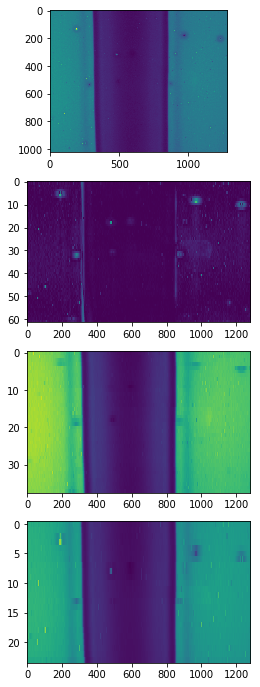

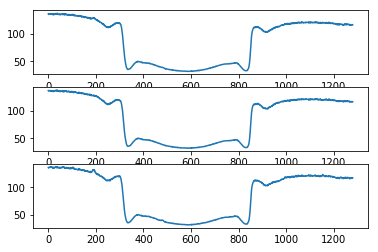

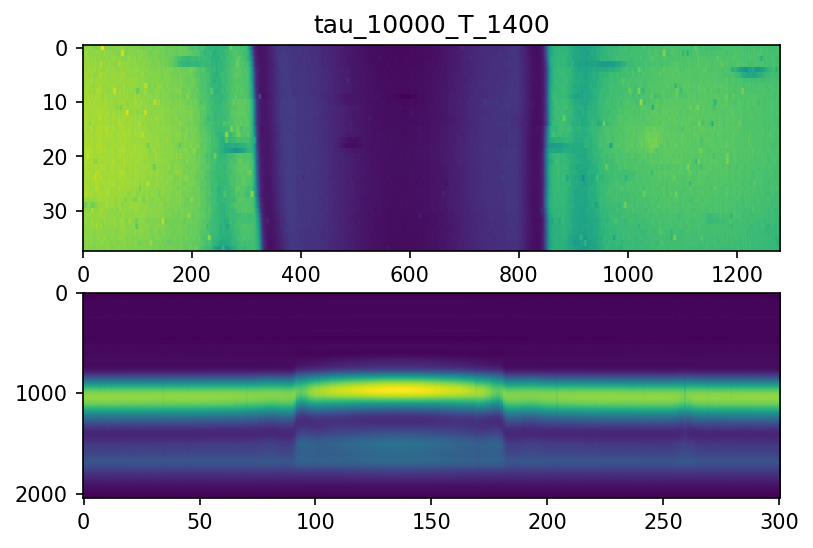

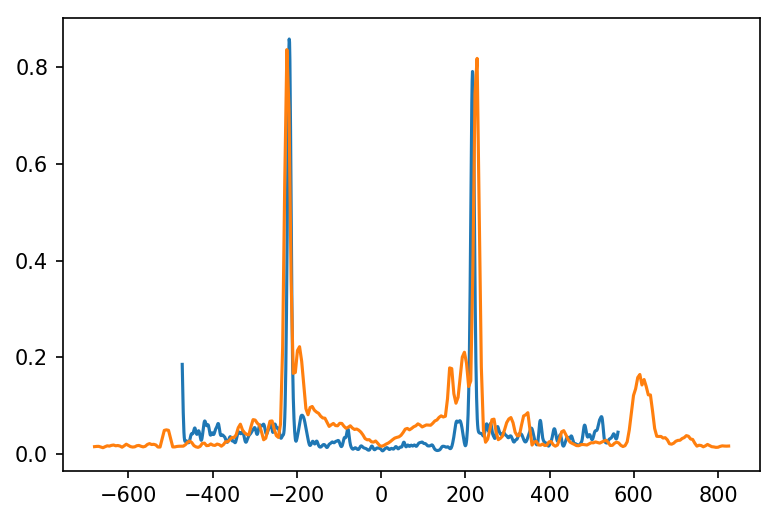

In [38]:
omap = s.Optmap(key)
omap = DustCollector(omap,binsize=15,exc_z=3,filt_crit=5,plotting=True)[0]
smap = s.Specmap(key)[1]

ops = .808
sps = 5
ox = np.linspace(0,omap.shape[1]*ops,omap.shape[1])
sx = np.linspace(0,smap.shape[1]*sps,smap.shape[1])

ox = ox - ocenter*(ops)
sx = sx - scenter*(sps)

fig,ax = plt.subplots(2,1,dpi=150)
ax[0].imshow(omap,aspect='auto')
ax[1].imshow(smap,aspect='auto')
ax[0].set_title(key)
plt.show()
plt.close()

plt.figure(dpi=150)
plt.plot(ox,og)
plt.plot(sx,sg)
plt.show()
plt.close()

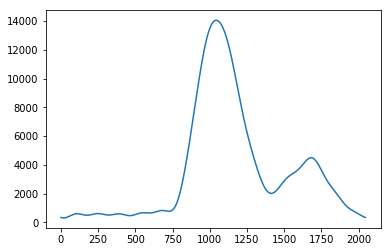

In [30]:
plt.plot(smap[:,1])